# Random Forest Classifier

### Complexity: O(m.n.n.log(n))

n = samples

m = features

In [1]:
import pandas as pd

seed = 's10'

# Double Pole
base = '../../../../datalake/data_baseline/data/xdpole/initialconditions'
n_features = 6

ic = pd.read_csv(f"{base}/{seed}_run.csv")

In [2]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from utils import get_label

sampler = RandomOverSampler(random_state=0)

features = ic.columns[[i for i in range(n_features)]]
target = 'performance'
X, y = ic[features], ic[target]

<Axes: xlabel='performance', ylabel='Count'>

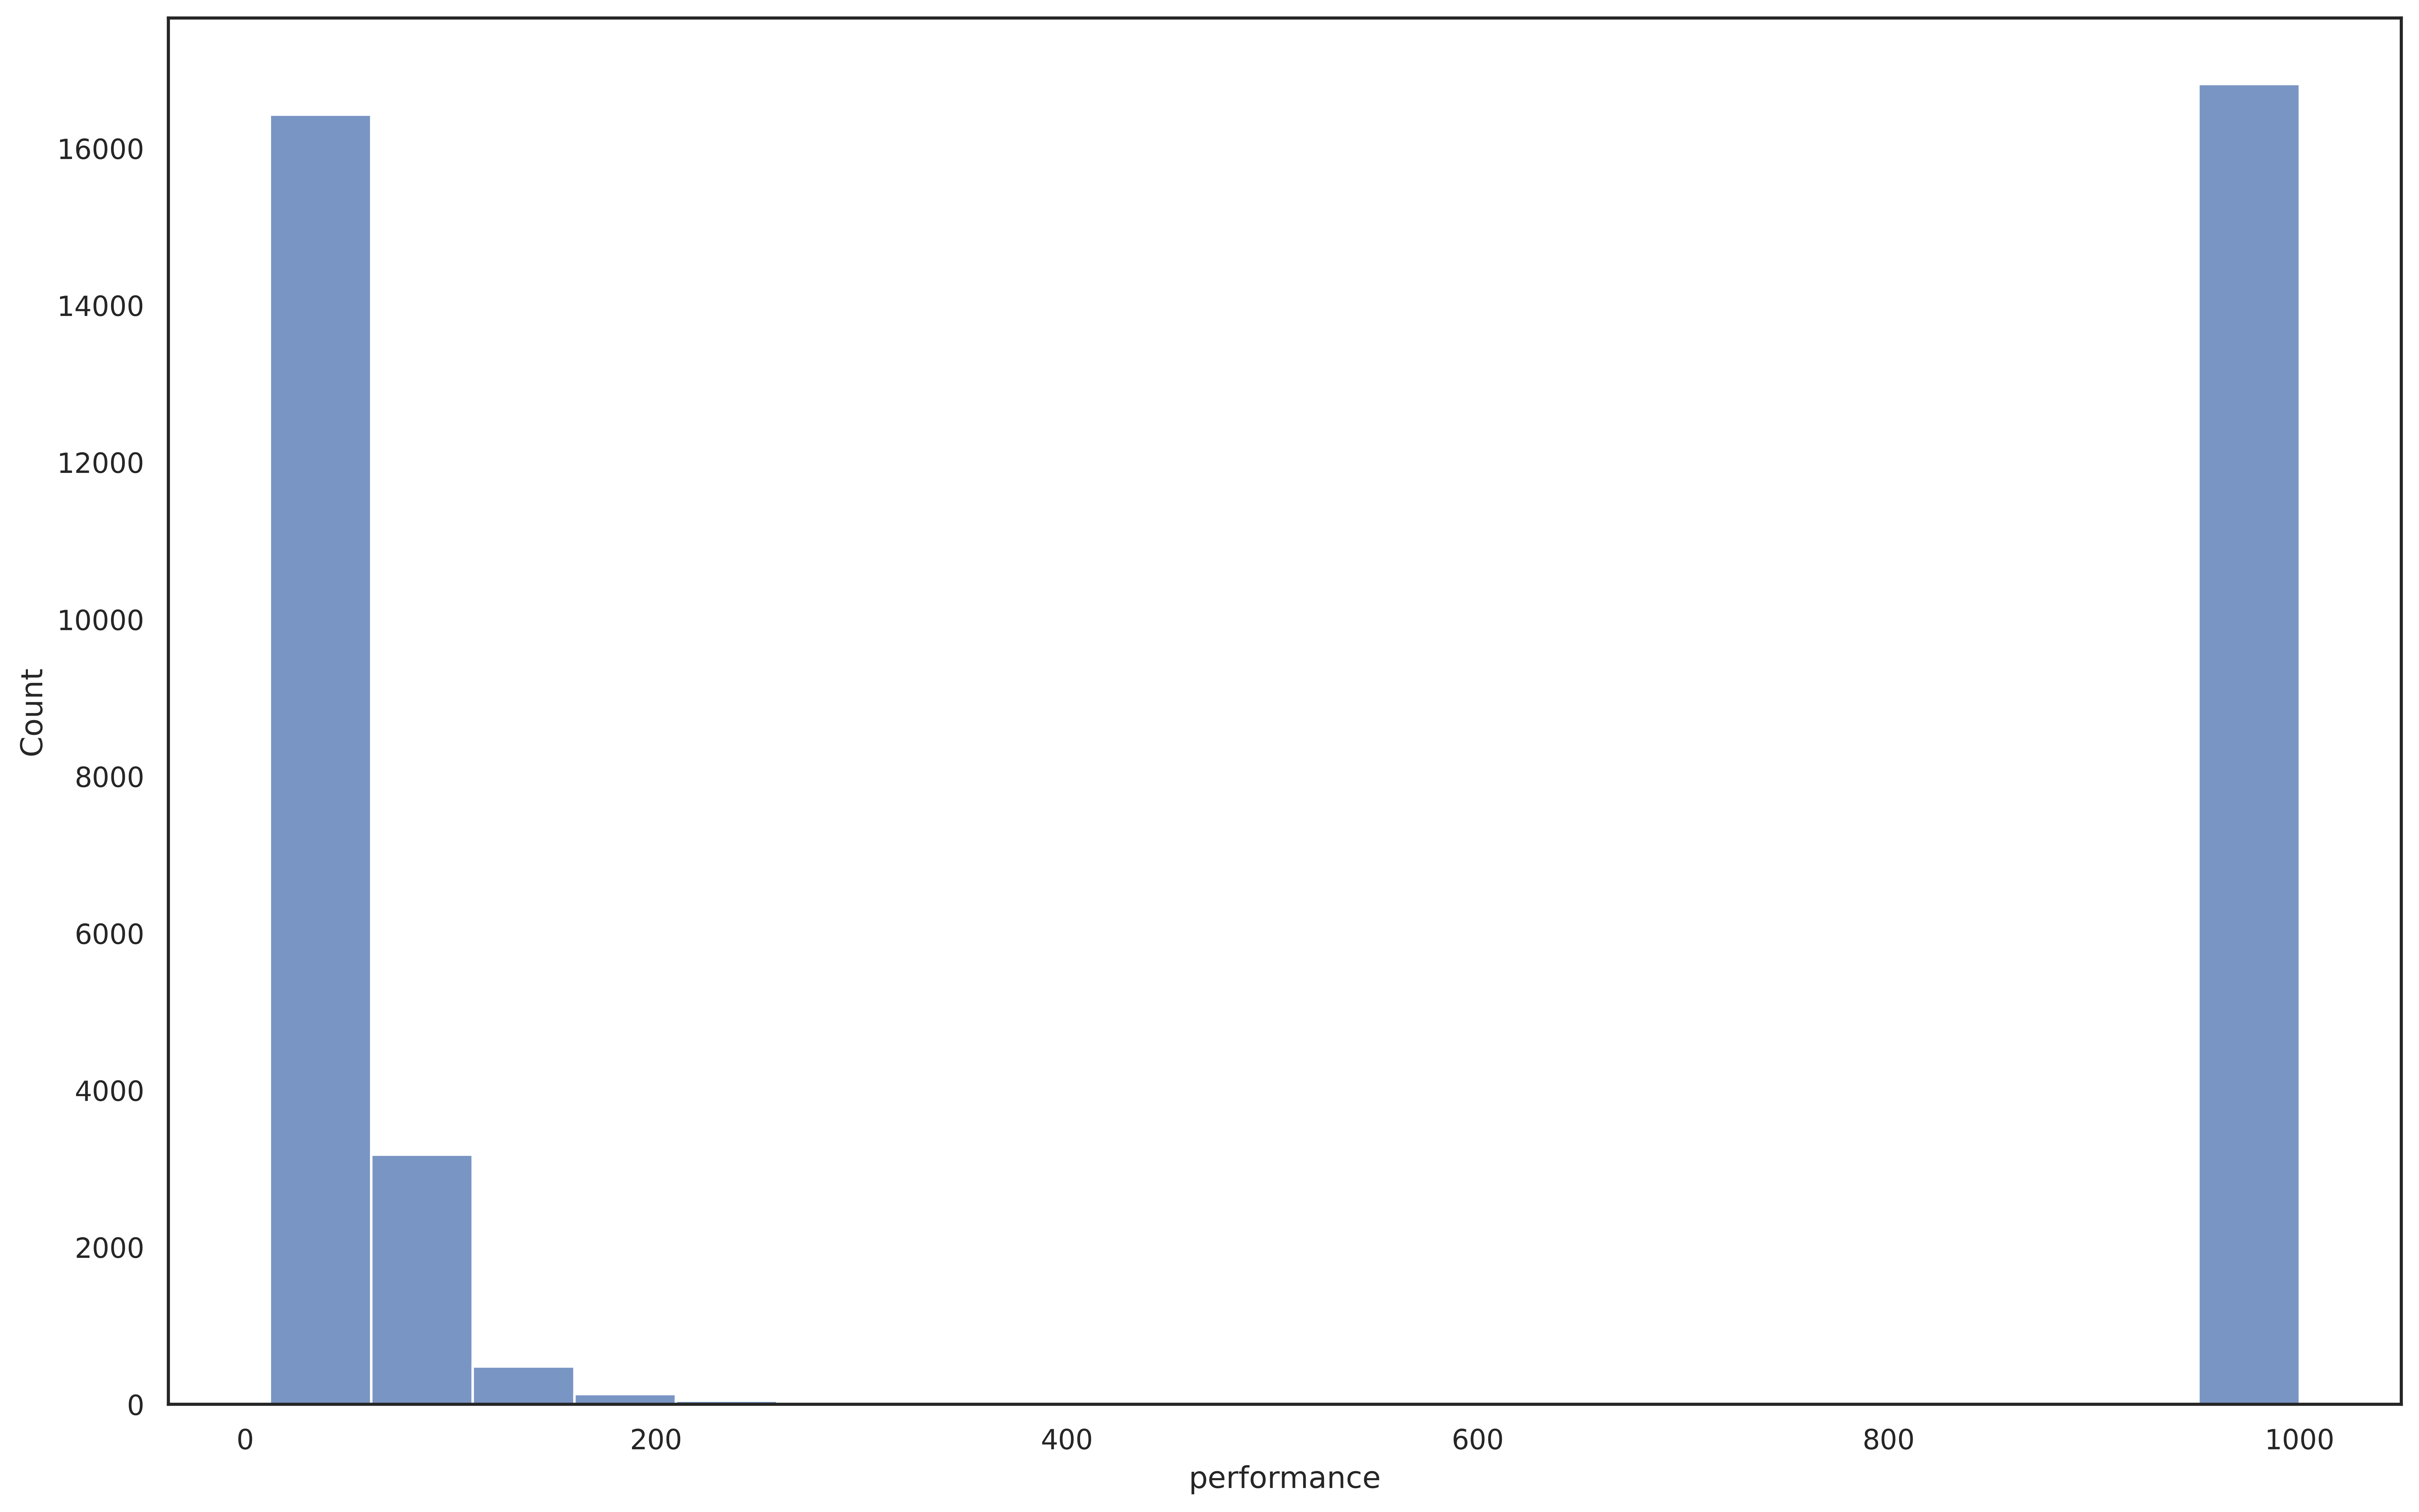

In [3]:
import seaborn as sns
from utils import graph_defaults
graph_defaults()

sns.histplot(y, bins=20)

<Axes: ylabel='Count'>

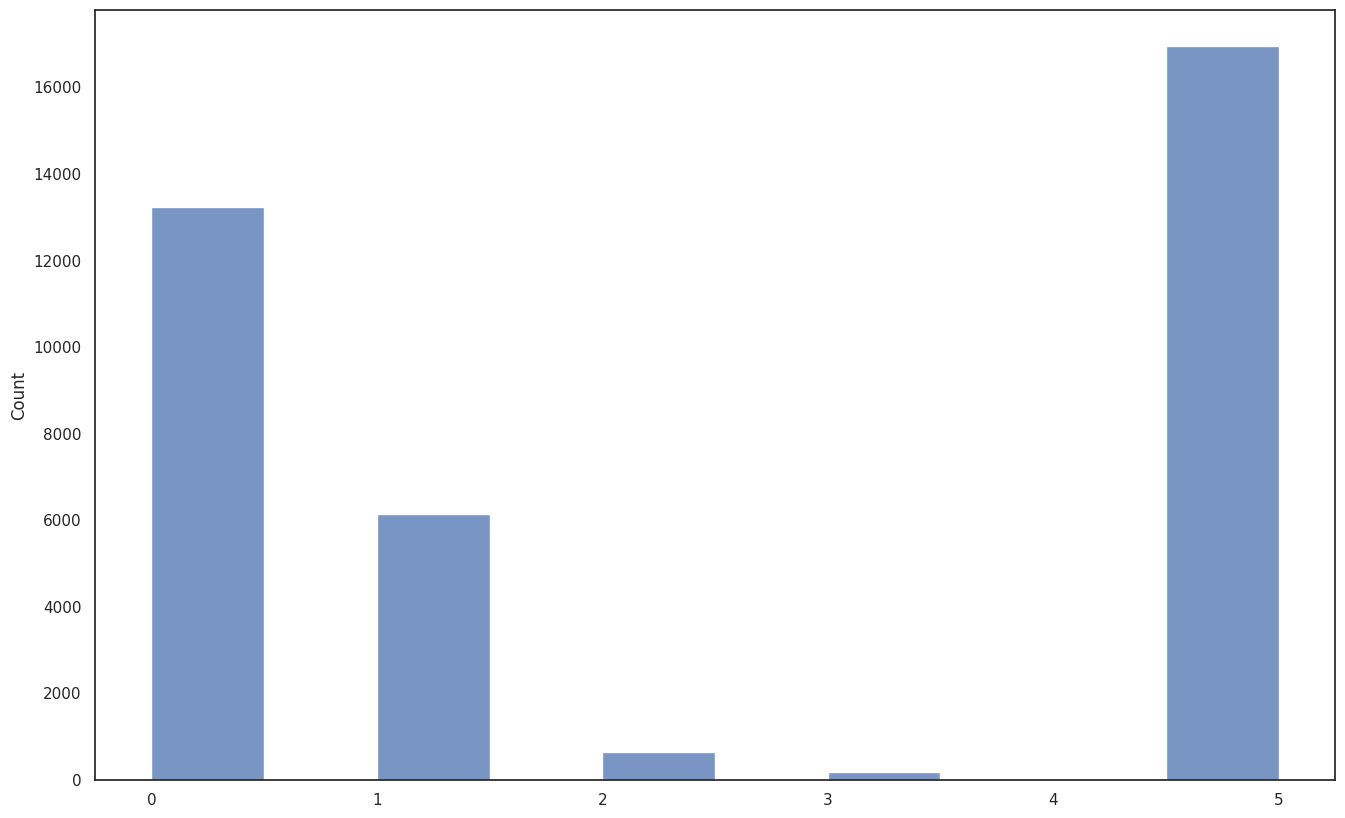

In [4]:
start = 1000 * 10
y = [get_label(yi) for yi in y]

sns.histplot(y, bins=10)

<Axes: ylabel='Count'>

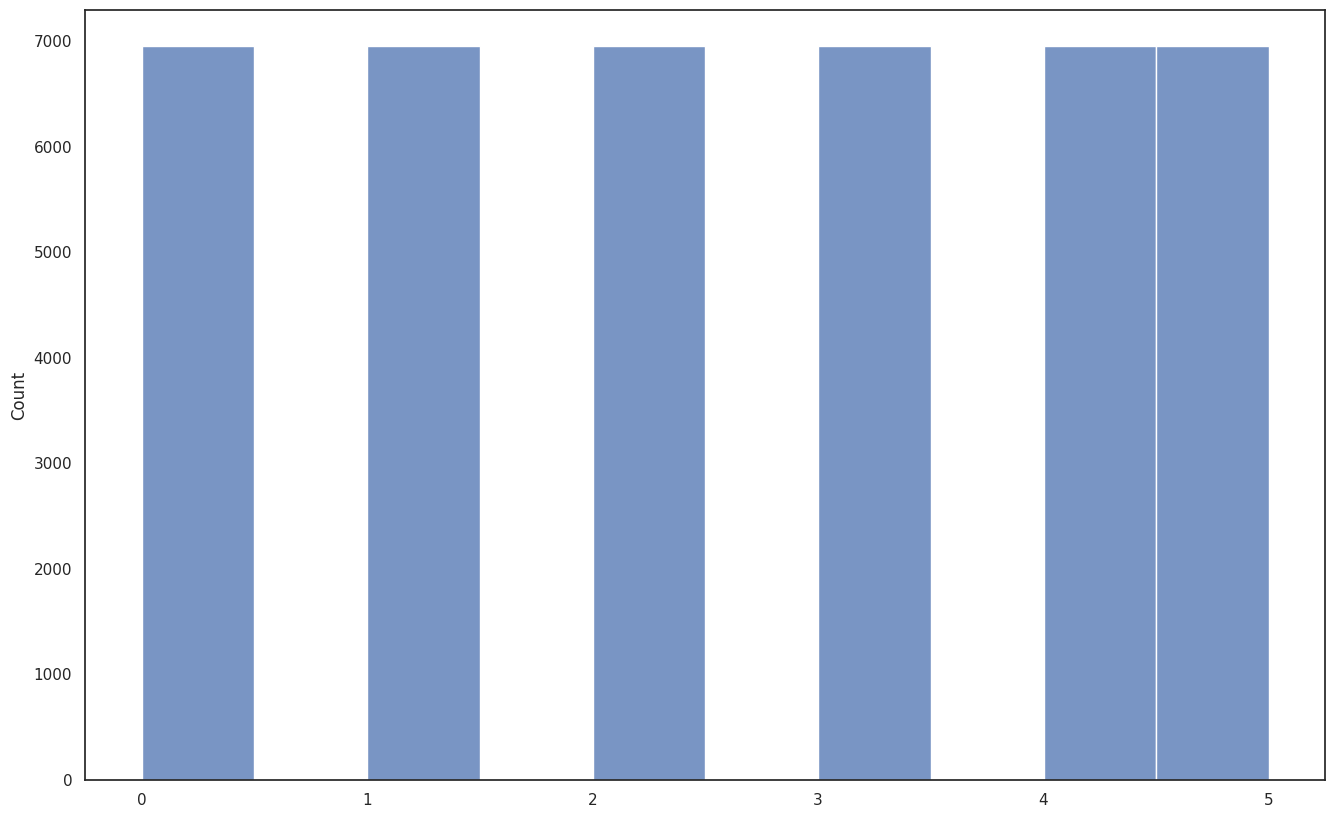

In [5]:
X, y = sampler.fit_resample(X[:start], y[:start])
sns.histplot(y, bins=10)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
import numpy as np
from utils import fit_cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

reg = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, warm_start=True),
    param_distributions=grid,
    n_iter=100,
    cv=3,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

params = fit_cv(reg, (X_train, y_train), 'random_forest')
print(params)

{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini'}


In [8]:
from critic import evolution

def model(X=[], y=[]):
    m = RandomForestClassifier(**params)
    if len(X) + len(y) > 0:
        m.fit(X, y)
    return m

s, p, t = evolution(X, y, model, batch=10)
print(t)

163.71656723299998


<Axes: >

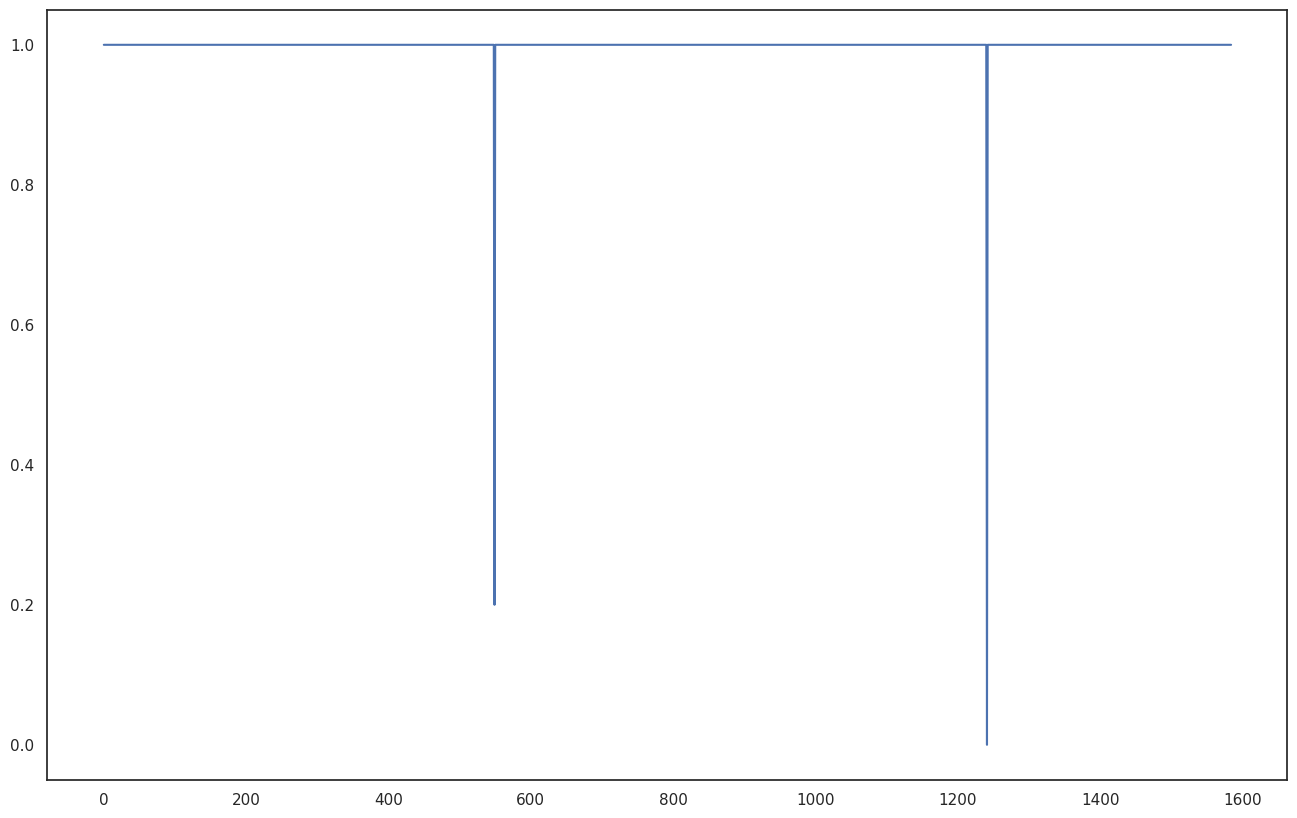

In [9]:
sns.lineplot(s)

<Axes: ylabel='Count'>

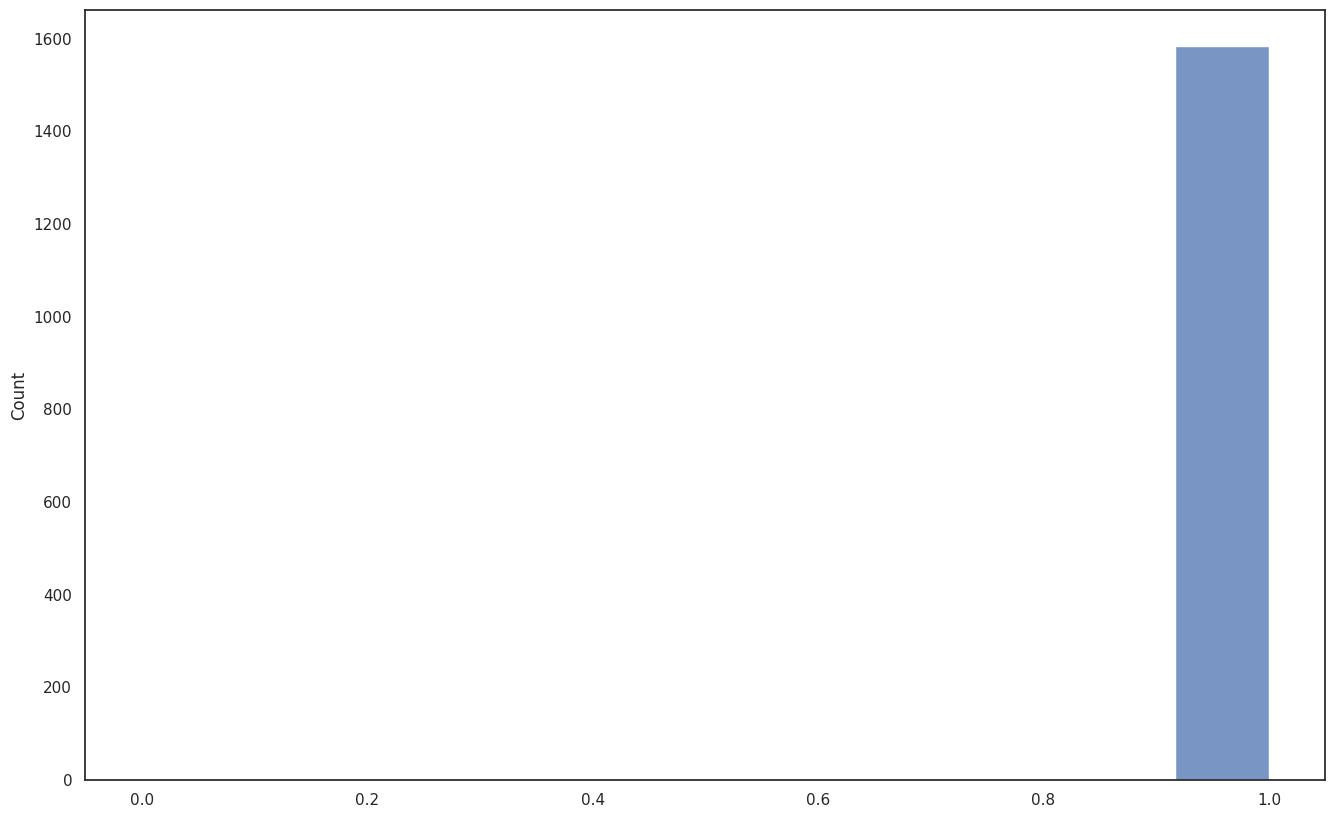

In [10]:
sns.histplot(s)

<Axes: ylabel='Count'>

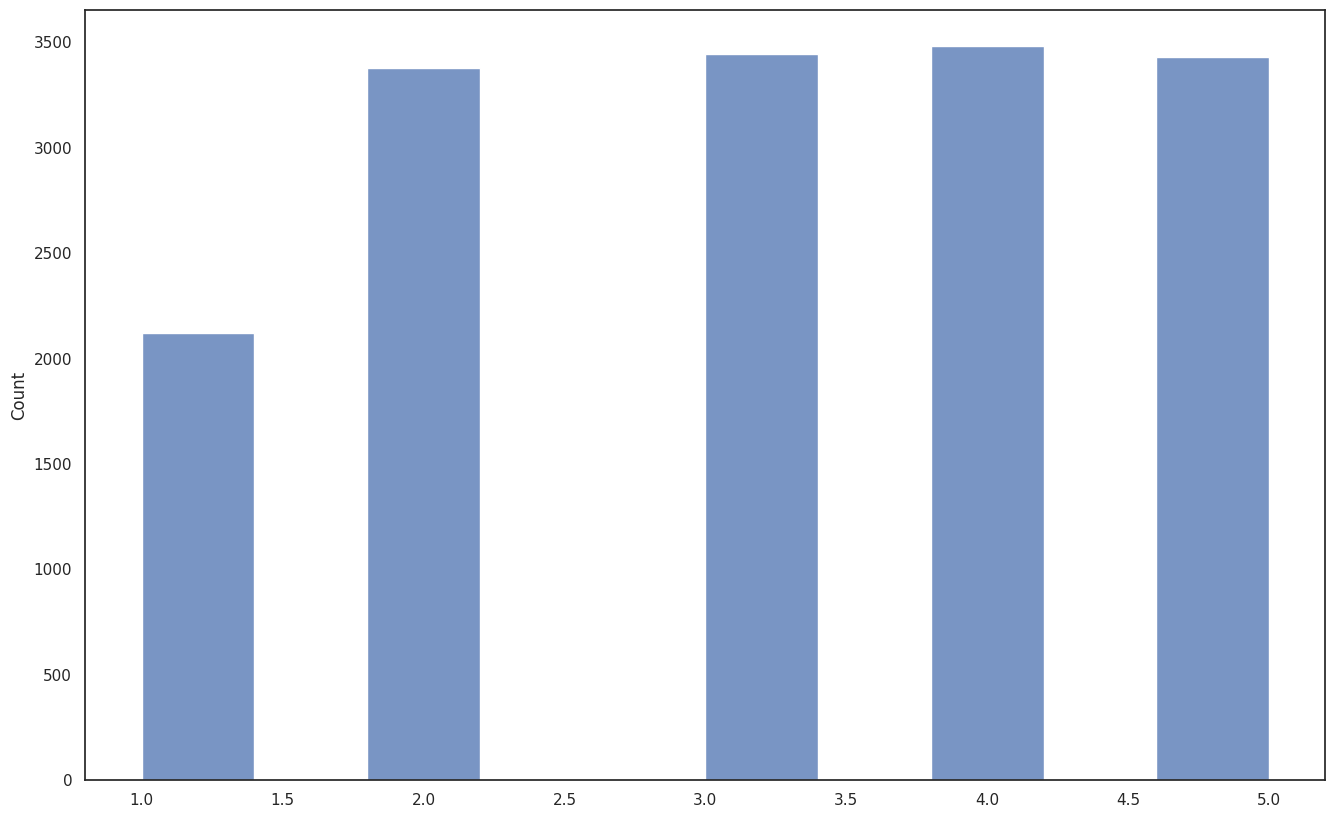

In [11]:
p = [yp for gen in p for yp in gen]

sns.histplot(p, bins=10)

In [12]:
yt = [y[i] for i in range(start+1, len(y), 2)]

e = [p[i]/yt[i] for i in range(len(p))]
e_df = pd.DataFrame(e)
e_df.describe()

,0
count,15850.000000
mean,0.999832
std,0.006902
min,0.666667
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


<Axes: ylabel='pos'>

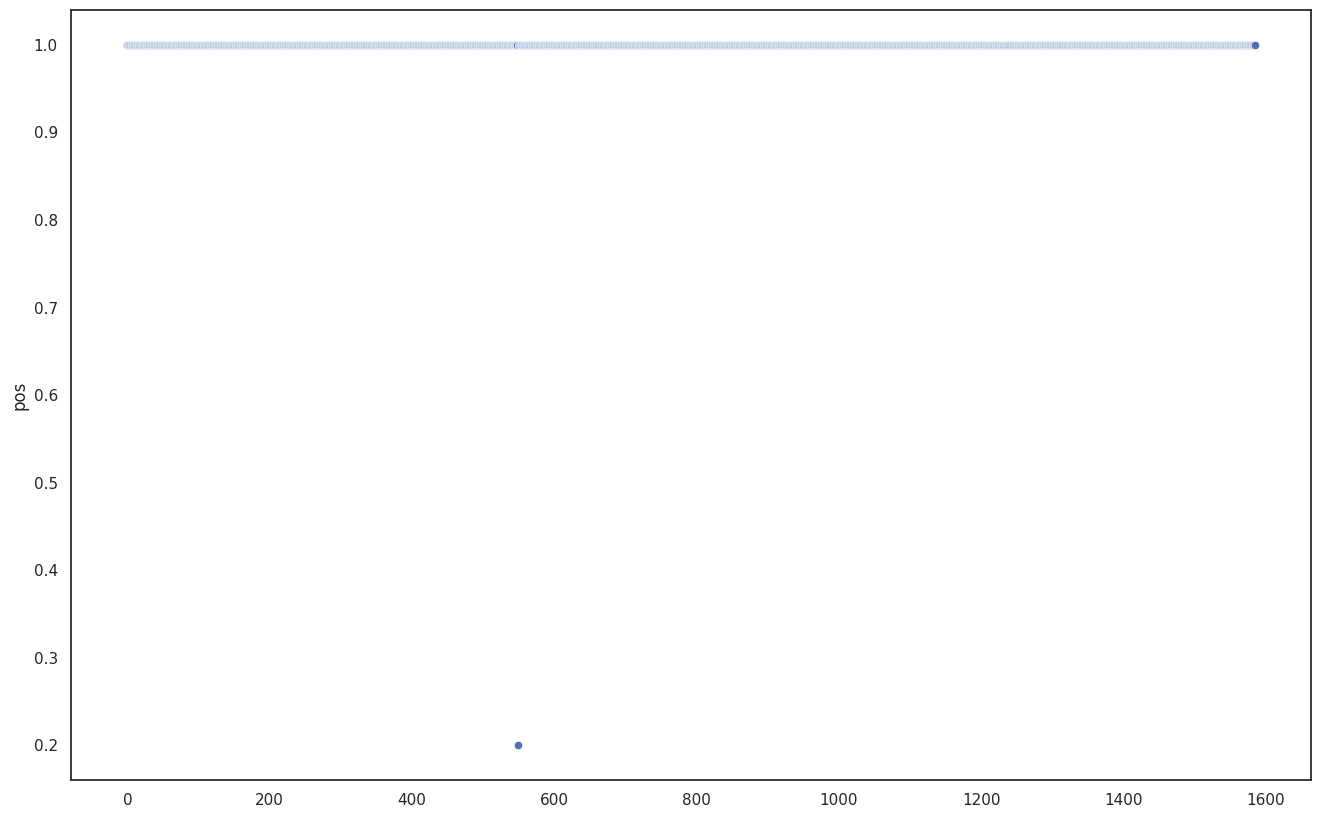

In [13]:
s_df = pd.DataFrame(s)
s_df.columns = ['raw']

s_df['pos'] = s_df.query('raw > 0').raw
s_df['neg'] = s_df.query('raw < 0').raw

sns.scatterplot(s_df['pos'])

<Axes: >

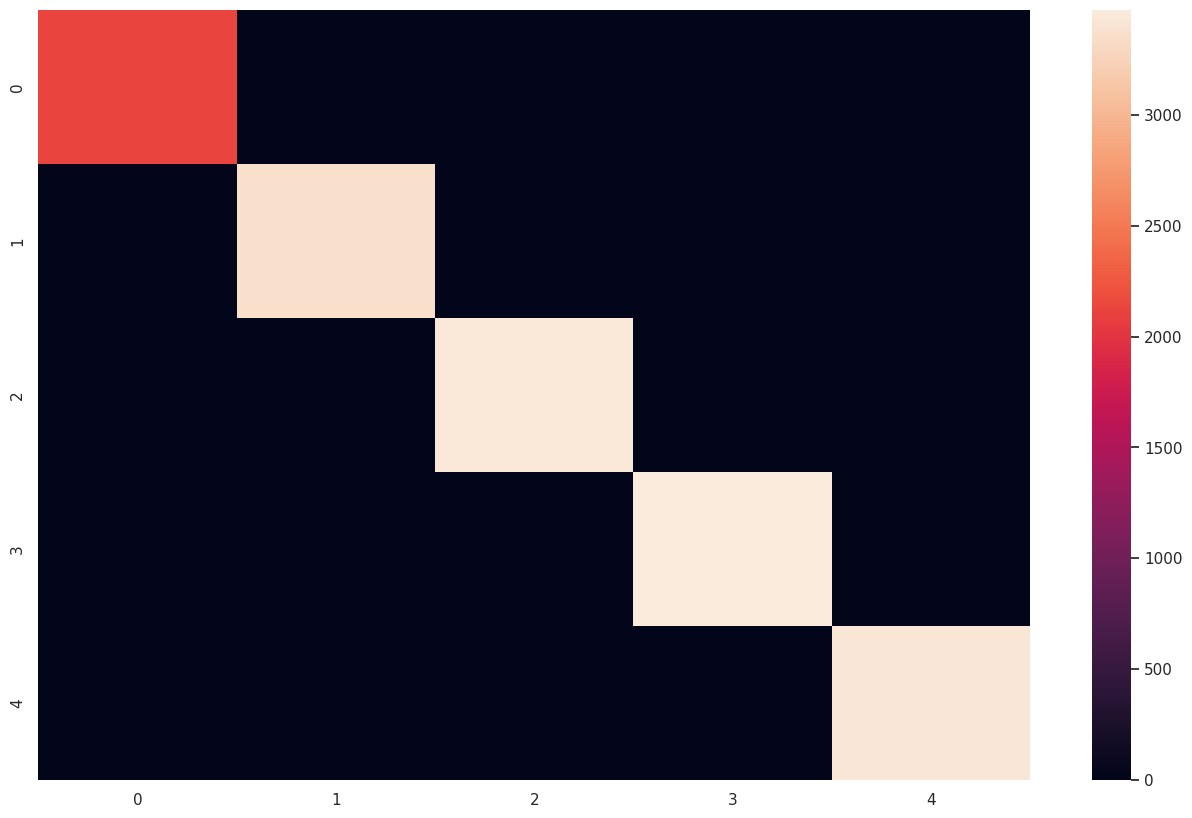

In [14]:
from sklearn.metrics import confusion_matrix

t = [yt[i] for i in range(len(p))]

sns.heatmap(confusion_matrix(t, p))